In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from chesswinnerprediction import plot_pie, plot_draw_percentage_by_base_time
from config import ROOT_DIR

In [4]:
data_path = os.path.join(ROOT_DIR, "data", "raw", "lichess_db_standard_rated_2017-03", "data_0.csv")
original_df = pd.read_csv(data_path)

In [5]:
baseline_columns = [
    "Event",
    "WhiteElo",
    "BlackElo",
    "TimeControl",
    "Result",
]
TARGET_COLUMNS = ["ResultEncoded", "WhiteWin", "BlackWin", "Draw"]

WHITE_WIN = "1-0"
BLACK_WIN = "0-1"
DRAW = "1/2-1/2"

RESULTS = {
    WHITE_WIN: 1,
    BLACK_WIN: 0,
    DRAW: -1
}

In [6]:
df = original_df[baseline_columns]
df = df[df["Result"] != "*"]

df["Event"] = df["Event"].str.split(" http").str[0]

df["WhiteElo"] = df["WhiteElo"].astype(np.int16)
df["BlackElo"] = df["BlackElo"].astype(np.int16)
df["MeanElo"] = ((df["WhiteElo"] + df["BlackElo"]) / 2).astype(np.float32)
df["EloDiff"] = (df["WhiteElo"] - df["BlackElo"]).astype(np.int16)
# df["EloDiffAbs"] = df["EloDiff"].abs().astype(np.int16)

df[["BaseTime", "IncrementTime"]] = df["TimeControl"].str.split("+", expand=True)
df["BaseTime"] = df["BaseTime"].astype(np.int16)
df["IncrementTime"] = df["IncrementTime"].astype(np.int16)
df["ZeroIncrementTime"] = (df["IncrementTime"] == 0).astype(np.int8)

df["ResultEncoded"] = df["Result"].map(RESULTS)
df["WhiteWin"] = (df["Result"] == "1-0").astype(np.int8)
df["BlackWin"] = (df["Result"] == "0-1").astype(np.int8)
df["Draw"] = (df["Result"] == "1/2-1/2").astype(np.int8)

df.drop(columns=["TimeControl"], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Event              25000 non-null  object 
 1   WhiteElo           25000 non-null  int16  
 2   BlackElo           25000 non-null  int16  
 3   Result             25000 non-null  object 
 4   MeanElo            25000 non-null  float32
 5   EloDiff            25000 non-null  int16  
 6   BaseTime           25000 non-null  int16  
 7   IncrementTime      25000 non-null  int16  
 8   ZeroIncrementTime  25000 non-null  int8   
 9   ResultEncoded      25000 non-null  int64  
 10  WhiteWin           25000 non-null  int8   
 11  BlackWin           25000 non-null  int8   
 12  Draw               25000 non-null  int8   
dtypes: float32(1), int16(5), int64(1), int8(4), object(2)
memory usage: 1.0+ MB


In [8]:
df.head()

,Event,WhiteElo,BlackElo,Result,MeanElo,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw
0,Rated Blitz game,1234,1467,0-1,1350.5,-233,300,0,1,0,0,1,0
1,Rated Blitz game,1988,1960,1-0,1974.0,28,180,0,1,1,1,0,0
2,Rated Blitz game,1891,1900,1-0,1895.5,-9,300,0,1,1,1,0,0
3,Rated Classical game,1342,1364,1-0,1353.0,-22,600,0,1,1,1,0,0
4,Rated Classical game,1575,1630,0-1,1602.5,-55,900,15,0,0,0,1,0


## Idea
Result depends on the Elo of the players. Let's see correlation between Elo and Result.

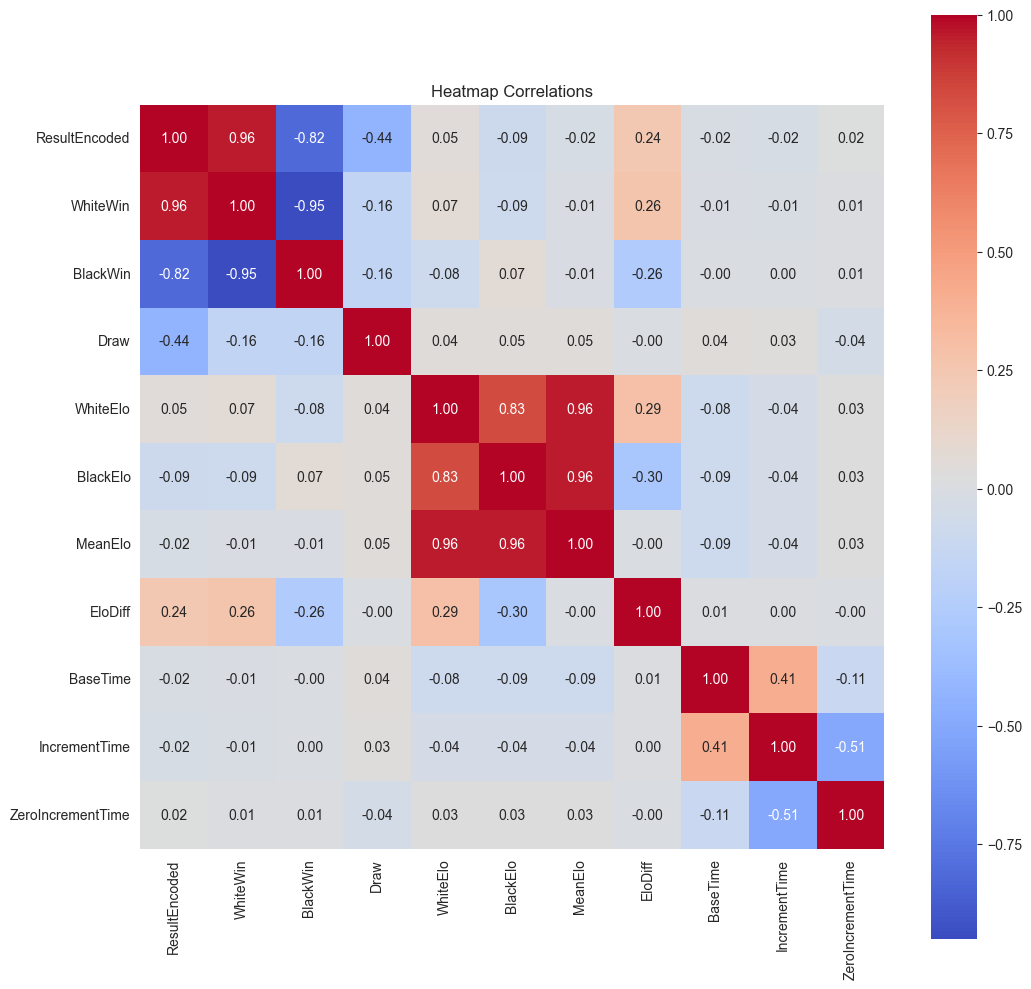

In [9]:
def plot_heatmap(data):
    reordered_columns = TARGET_COLUMNS + [
        col for col in data.columns if col not in TARGET_COLUMNS
    ]
    data = data[reordered_columns]

    numeric_df = data.select_dtypes(include="number")
    plt.figure(figsize=(12, 12))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Heatmap Correlations")
    plt.show()


plot_heatmap(df)

White elo has positive correlation with white win and negative correlation with black win. Same for black elo.

Also, Elo has small correlation with draw.

Let's see the distribution of the results, where:
   - "1-0": White wins
   - "0-1": Black wins
   - "1/2-1/2": Draw

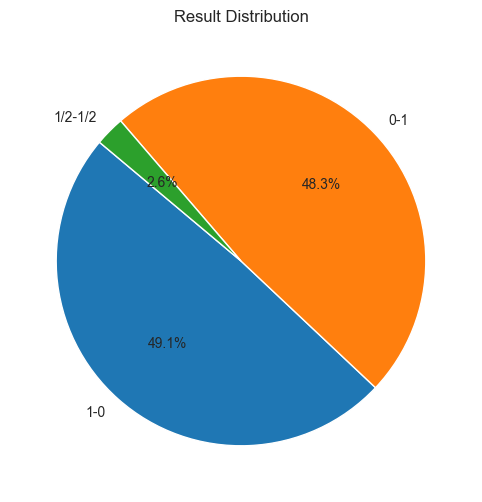

In [10]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Result", "Result Distribution", threshold=0)
plt.show()

And let's see the distribution of Events.

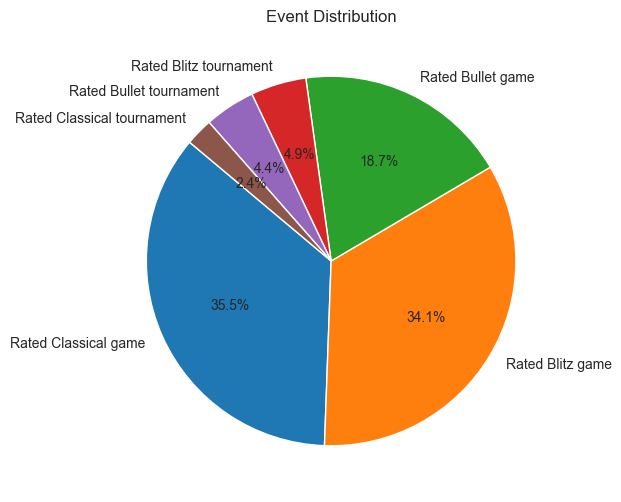

In [11]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Event", "Event Distribution", threshold=0.00)
plt.show()

And now - the distribution of the results for each event.

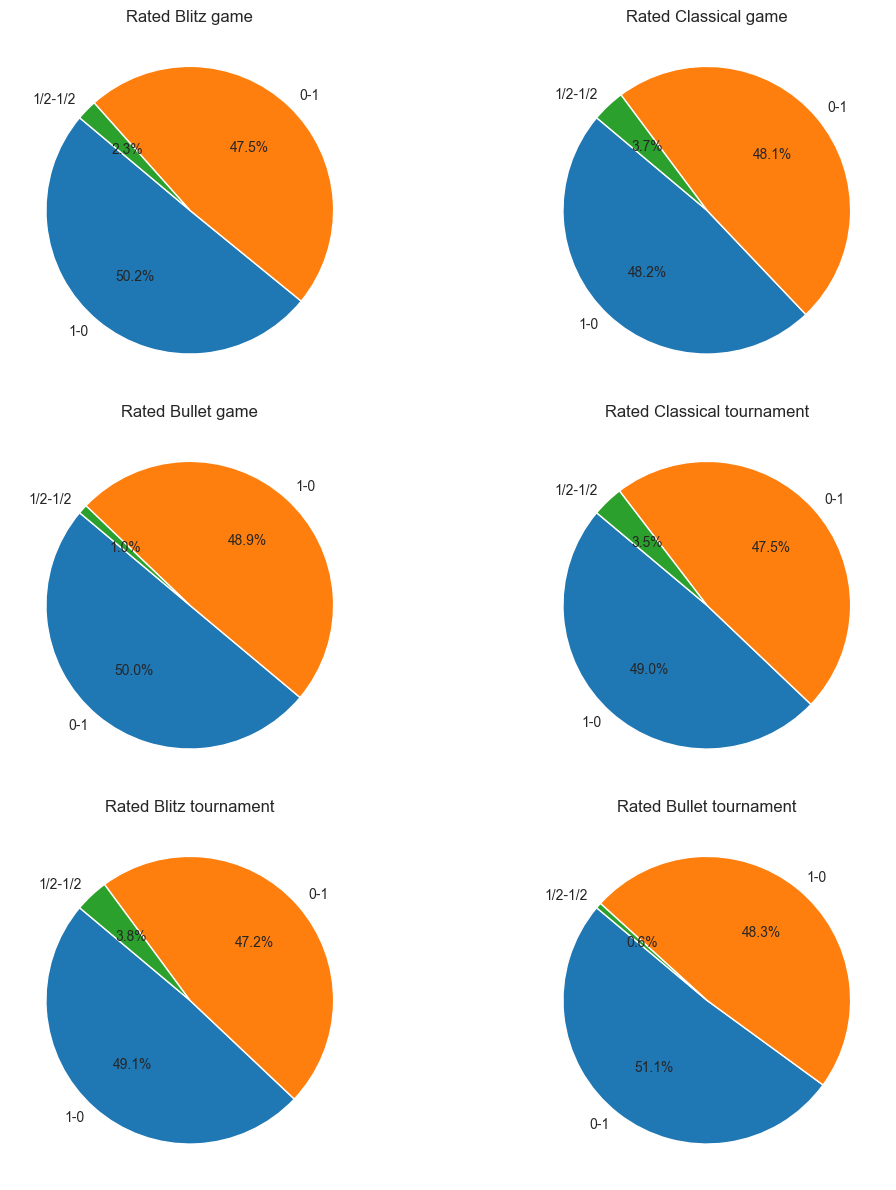

In [12]:
_, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]

events = df["Event"].unique()
for (i, j), event in zip(idx, events):
    event_df = df[df["Event"] == event]
    plot_pie(axs[i][j], event_df, column_name="Result", title=f"{event}", threshold=0)

plt.tight_layout()
plt.show()

## Elo vs Result

Let's compare mean Elo of all games and mean Elo of draws.

Mean Elo: 1622.5524
Mean Elo for Draw: 1702.2762


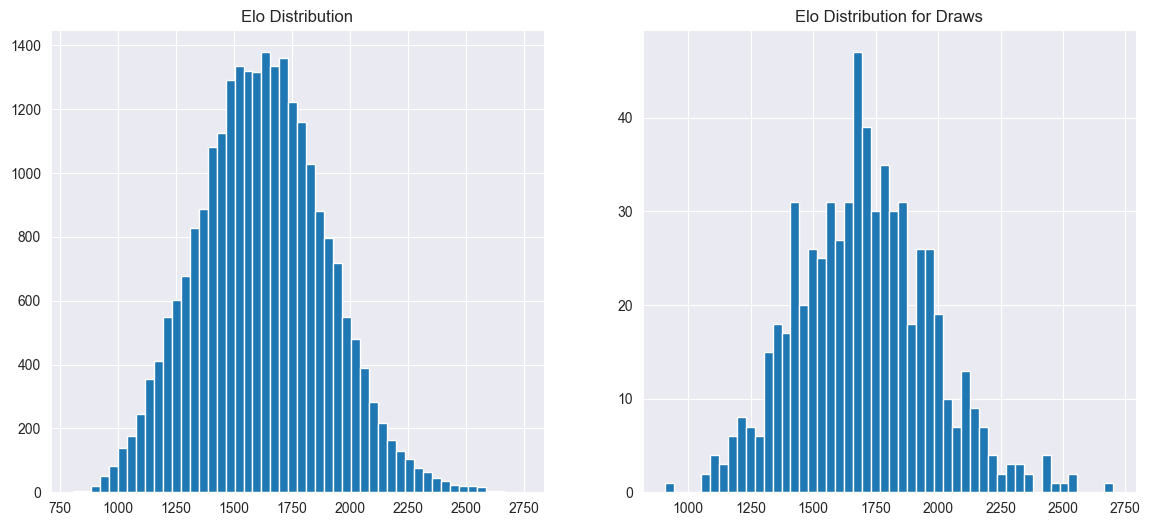

In [13]:
print("Mean Elo:", df["MeanElo"].mean())
print("Mean Elo for Draw:", df[df["Draw"] == 1]["MeanElo"].mean())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df["MeanElo"].hist(bins=50, ax=axes[0])
axes[0].set_title("Elo Distribution")

df[df["Draw"] == 1]["MeanElo"].hist(bins=50, ax=axes[1])
axes[1].set_title("Elo Distribution for Draws")

plt.show()

Draws have higher mean Elo.

And let's compare mean winner elo with mean loser elo

white Wins
White mean elo: 1642.9496414602347
Black mean elo: 1597.8412646675358


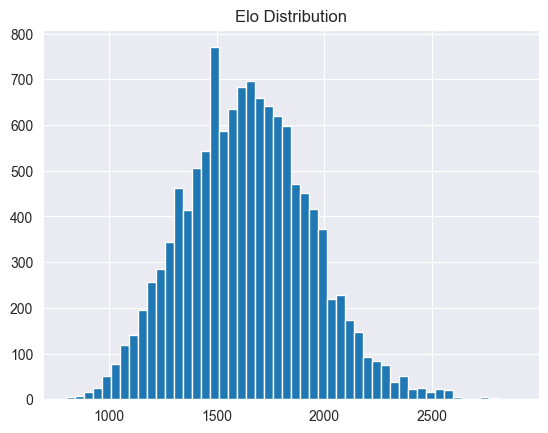

In [14]:
white_wins_df = df[df["WhiteWin"] == 1]
print("white Wins")
print("White mean elo:", white_wins_df["WhiteElo"].mean())
print("Black mean elo:", white_wins_df["BlackElo"].mean())

white_wins_df["WhiteElo"].hist(bins=50)
plt.title("Elo Distribution")
plt.show()

Black Wins
Black mean elo: 1644.148344370861
White mean elo: 1596.78559602649


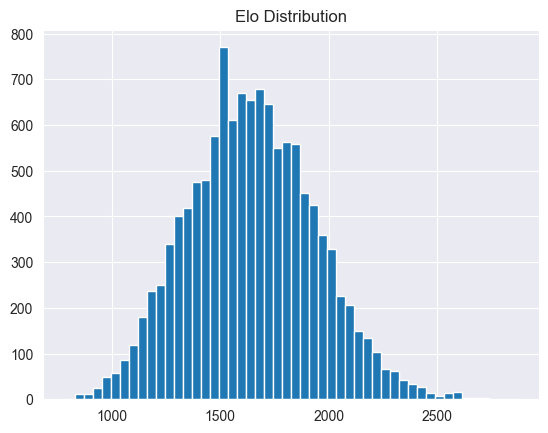

In [15]:
black_wins_df = df[df["BlackWin"] == 1]
print("Black Wins")
print("Black mean elo:", black_wins_df["BlackElo"].mean())
print("White mean elo:", black_wins_df["WhiteElo"].mean())

black_wins_df["BlackElo"].hist(bins=50)
plt.title("Elo Distribution")
plt.show()

In [16]:
del white_wins_df
del black_wins_df

## Time Control Exploration

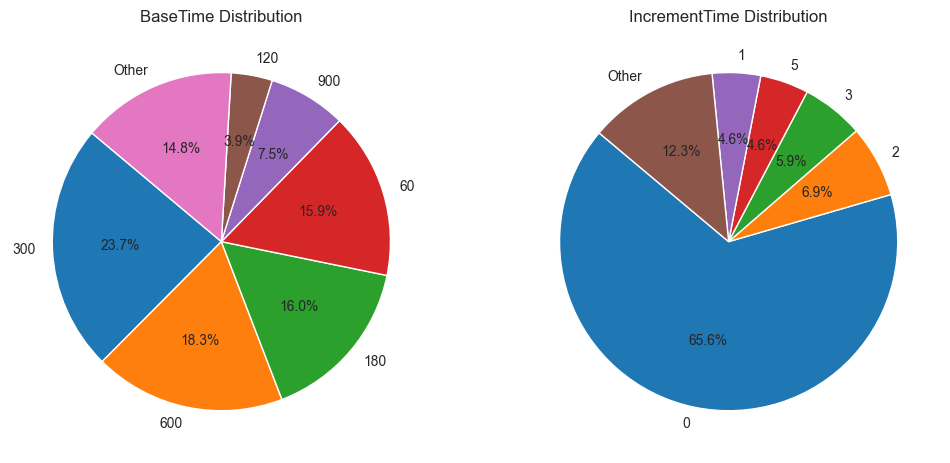

In [17]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_pie(axs[0], df, "BaseTime", "BaseTime Distribution", threshold=0.03)
plot_pie(axs[1], df, "IncrementTime", "IncrementTime Distribution", threshold=0.04)
plt.show()

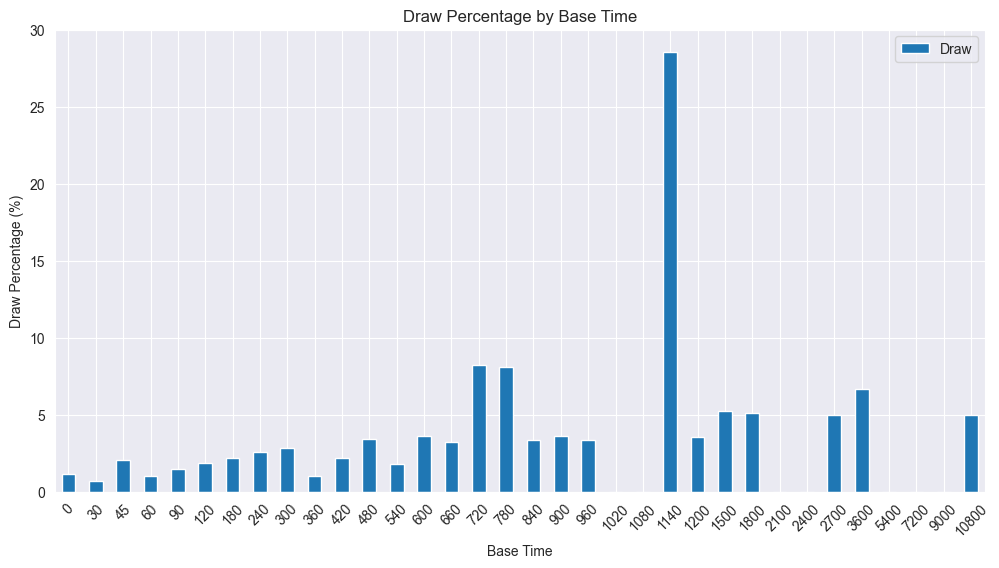

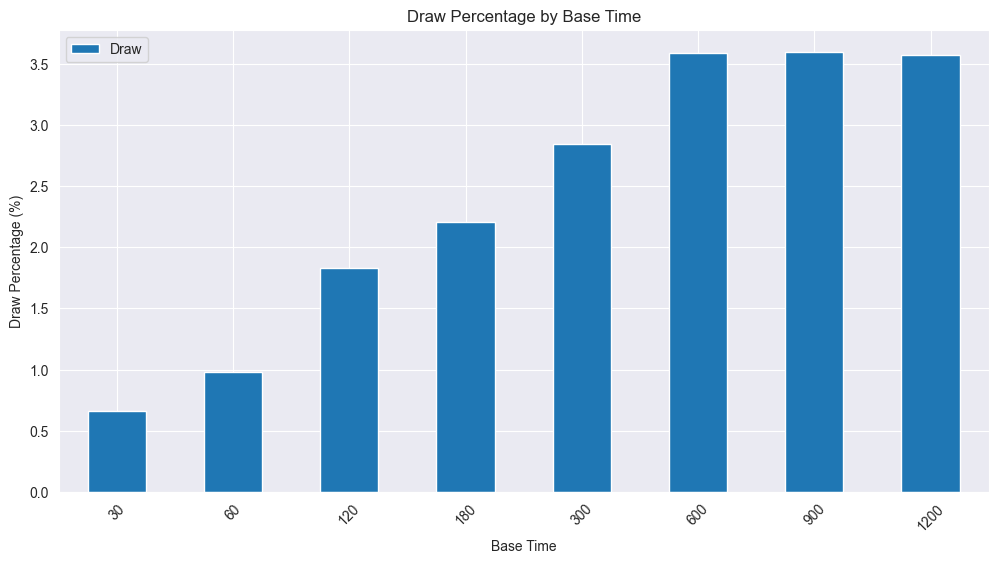

In [18]:
plot_draw_percentage_by_base_time(df)
plot_draw_percentage_by_base_time(df, base_times=8)

As more time is given, the draw percentage increases.

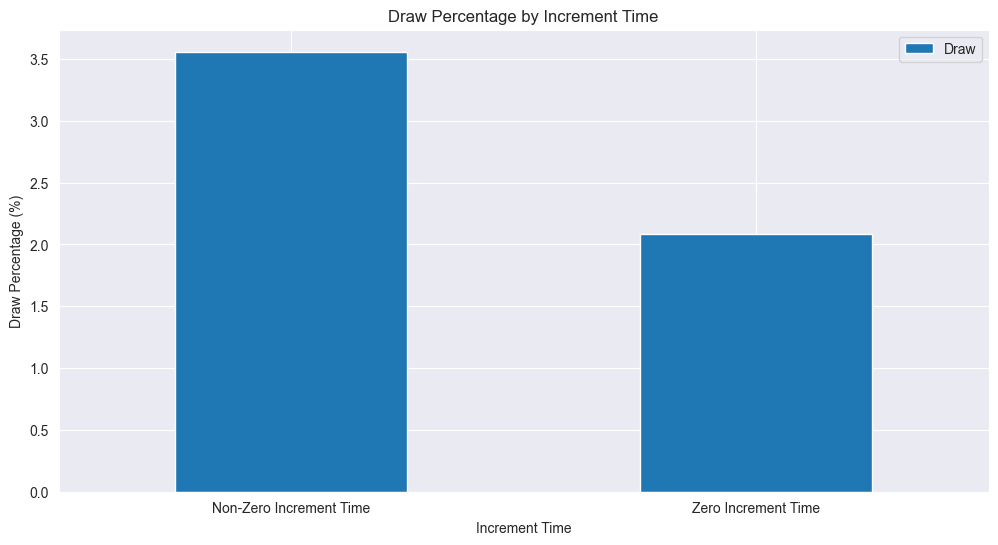

In [19]:
increment_time_df = df[["ZeroIncrementTime", "Draw"]].copy()
increment_time_df["ZeroIncrementTime"] = increment_time_df["ZeroIncrementTime"].map(
    {0: "Non-Zero Increment Time", 1: "Zero Increment Time"}
)
pct_draw_values = increment_time_df.groupby("ZeroIncrementTime").mean() * 100

ax = pct_draw_values.plot(kind="bar", figsize=(12, 6))
ax.set_title("Draw Percentage by Increment Time")
ax.set_ylabel("Draw Percentage (%)")
ax.set_xlabel("Increment Time")
plt.xticks(rotation=0)
plt.show()

non-zero increment time games have higher draw percentage.

In [20]:
df["DrawEventProb"] = df.groupby("Event")["Draw"].transform("mean")
df["WhiteWinEventProb"] = df.groupby("Event")["WhiteWin"].transform("mean")
df["BlackWinEventProb"] = df.groupby("Event")["BlackWin"].transform("mean")

In [21]:
df.head()

,Event,WhiteElo,BlackElo,Result,MeanElo,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb
0,Rated Blitz game,1234,1467,0-1,1350.5,-233,300,0,1,0,0,1,0,0.023024,0.502173,0.474803
1,Rated Blitz game,1988,1960,1-0,1974.0,28,180,0,1,1,1,0,0,0.023024,0.502173,0.474803
2,Rated Blitz game,1891,1900,1-0,1895.5,-9,300,0,1,1,1,0,0,0.023024,0.502173,0.474803
3,Rated Classical game,1342,1364,1-0,1353.0,-22,600,0,1,1,1,0,0,0.037033,0.481990,0.480977
4,Rated Classical game,1575,1630,0-1,1602.5,-55,900,15,0,0,0,1,0,0.037033,0.481990,0.480977


In [22]:
# df["EventMeanElo"] = df.groupby("Event")["MeanElo"].transform("mean")
# df["EventMeanEloDiff"] = df.groupby("Event")["EloDiff"].transform("mean")
# df["EventMeanEloDiffAbs"] = df.groupby("Event")["EloDiffAbs"].transform("mean")

In [23]:
# df["MeanEloDivWhiteWinProb"] = df["MeanElo"] / df["WhiteWinEventProb"]
# df["MeanEloDivBlackWinProb"] = df["MeanElo"] / df["BlackWinEventProb"]
# df["MeanEloDivDrawProb"] = df["MeanElo"] / df["RawEventProb"]

In [24]:
# df["EloDiffDivWhiteWinProb"] = df["EloDiff"] / df["WhiteWinEventProb"]
# df["EloDiffDivBlackWinProb"] = df["EloDiff"] / df["BlackWinEventProb"]
# df["EloDiffDivDrawProb"] = df["EloDiff"] / df["RawEventProb"]

In [25]:
# df["EloDiffAbsDivWhiteWinProb"] = df["EloDiffAbs"] / df["WhiteWinEventProb"]
# df["EloDiffAbsDivBlackWinProb"] = df["EloDiffAbs"] / df["BlackWinEventProb"]
# df["EloDiffAbsDivDrawProb"] = df["EloDiffAbs"] / df["RawEventProb"]

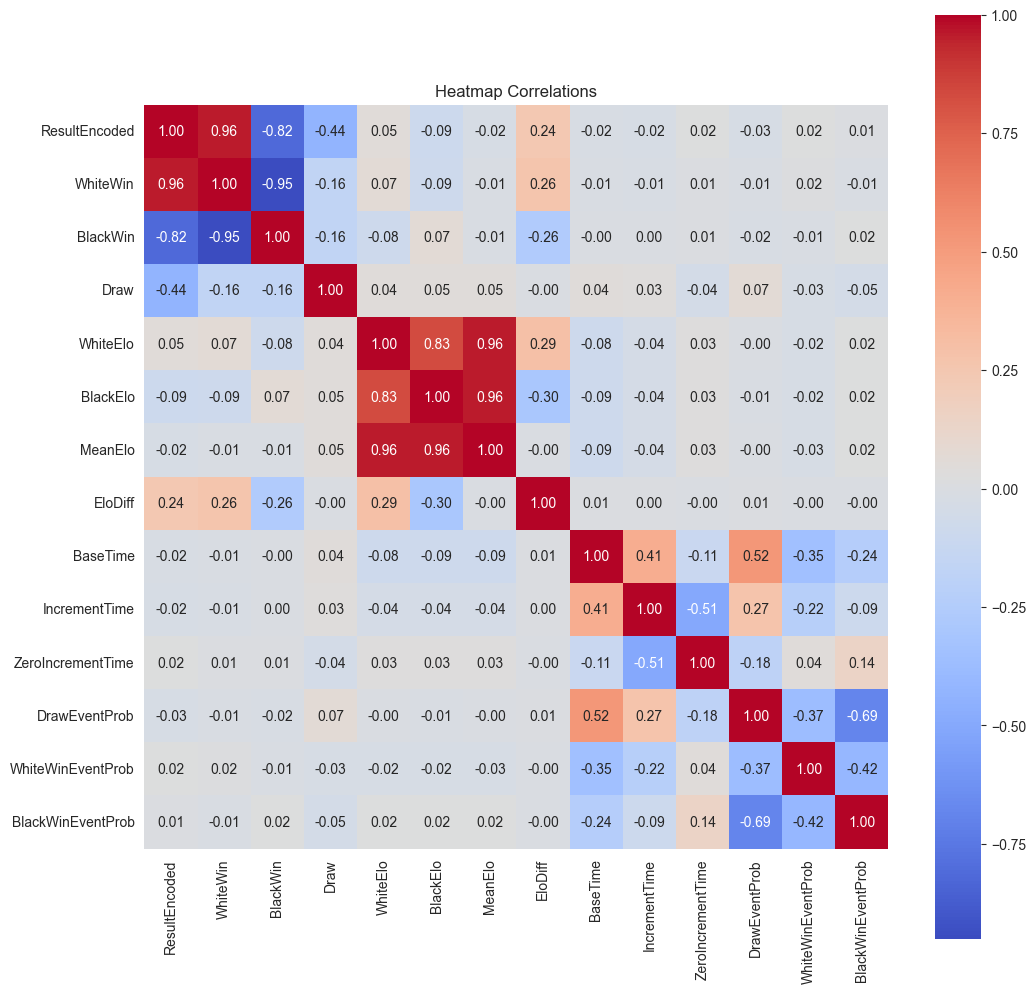

In [26]:
plot_heatmap(df)

In [27]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8)

In [28]:
df.drop(columns=["Result"], inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   WhiteElo                          25000 non-null  int16  
 1   BlackElo                          25000 non-null  int16  
 2   MeanElo                           25000 non-null  float32
 3   EloDiff                           25000 non-null  int16  
 4   BaseTime                          25000 non-null  int16  
 5   IncrementTime                     25000 non-null  int16  
 6   ZeroIncrementTime                 25000 non-null  int8   
 7   ResultEncoded                     25000 non-null  int64  
 8   WhiteWin                          25000 non-null  int8   
 9   BlackWin                          25000 non-null  int8   
 10  Draw                              25000 non-null  int8   
 11  DrawEventProb                     25000 non-null  float64
 12  Whit

In [30]:
df.head()

,WhiteElo,BlackElo,MeanElo,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb,Event_Rated Blitz game,Event_Rated Blitz tournament,Event_Rated Bullet game,Event_Rated Bullet tournament,Event_Rated Classical game,Event_Rated Classical tournament
0,1234,1467,1350.5,-233,300,0,1,0,0,1,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
1,1988,1960,1974.0,28,180,0,1,1,1,0,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
2,1891,1900,1895.5,-9,300,0,1,1,1,0,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
3,1342,1364,1353.0,-22,600,0,1,1,1,0,0,0.037033,0.481990,0.480977,0,0,0,0,1,0
4,1575,1630,1602.5,-55,900,15,0,0,0,1,0,0.037033,0.481990,0.480977,0,0,0,0,1,0


In [31]:
def estimate_prediction_by_elo(data_df: pd.DataFrame):
    white_elo_more_than_black = data_df["WhiteElo"] > data_df["BlackElo"]
    
    white_win_condition = white_elo_more_than_black & (data_df["WhiteWin"] == 1)
    black_win_condition = ~white_elo_more_than_black & (data_df["BlackWin"] == 1)
    
    right_predictions = len(data_df[white_win_condition]) + len(data_df[black_win_condition])
    return right_predictions / len(data_df)

In [32]:
estimate_prediction_by_elo(df)

0.5868

In [33]:
df.head()

,WhiteElo,BlackElo,MeanElo,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb,Event_Rated Blitz game,Event_Rated Blitz tournament,Event_Rated Bullet game,Event_Rated Bullet tournament,Event_Rated Classical game,Event_Rated Classical tournament
0,1234,1467,1350.5,-233,300,0,1,0,0,1,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
1,1988,1960,1974.0,28,180,0,1,1,1,0,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
2,1891,1900,1895.5,-9,300,0,1,1,1,0,0,0.023024,0.502173,0.474803,1,0,0,0,0,0
3,1342,1364,1353.0,-22,600,0,1,1,1,0,0,0.037033,0.481990,0.480977,0,0,0,0,1,0
4,1575,1630,1602.5,-55,900,15,0,0,0,1,0,0.037033,0.481990,0.480977,0,0,0,0,1,0
